# Imports

In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import joblib
import os
import warnings


warnings.filterwarnings("ignore")
RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)
plt.style.use('default')
matplotlib.rcParams['figure.figsize'] = (8,4)


CSV_PATH = "data/data.csv"
CLEANED_OUT = "data/cleaned_data.csv"
MODEL_OUT = "models"
os.makedirs(MODEL_OUT, exist_ok=True)

# Loading data

In [221]:
df = pd.read_csv(CSV_PATH, dtype=str, low_memory=False, quotechar='"', escapechar='\\')
df = df[df["Topic"] == "Obesity / Weight Status"].copy()
df_num = df.apply(pd.to_numeric, errors='coerce')
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())

Raw shape: (40040, 33)
Columns: ['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource', 'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type', 'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size', 'Total', 'Age(years)', 'Education', 'Sex', 'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID', 'StratificationCategory1', 'Stratification1', 'StratificationCategoryId1', 'StratificationID1']


# Exploratory Data Analysis

## Statistical Summary

In [222]:
print("Statistical Summary:")
print(df_num.describe(include='all'))

Statistical Summary:
          YearStart       YearEnd  LocationAbbr  LocationDesc  Datasource  \
count  40040.000000  40040.000000           0.0           0.0         0.0   
mean    2017.000000   2017.000000           NaN           NaN         NaN   
std        3.741704      3.741704           NaN           NaN         NaN   
min     2011.000000   2011.000000           NaN           NaN         NaN   
25%     2014.000000   2014.000000           NaN           NaN         NaN   
50%     2017.000000   2017.000000           NaN           NaN         NaN   
75%     2020.000000   2020.000000           NaN           NaN         NaN   
max     2023.000000   2023.000000           NaN           NaN         NaN   

       Class  Topic  Question  Data_Value_Unit  Data_Value_Type    Data_Value  \
count    0.0    0.0       0.0              0.0              0.0  35388.000000   
mean     NaN    NaN       NaN              NaN              NaN     32.713482   
std      NaN    NaN       NaN             

## Correlation Matrix

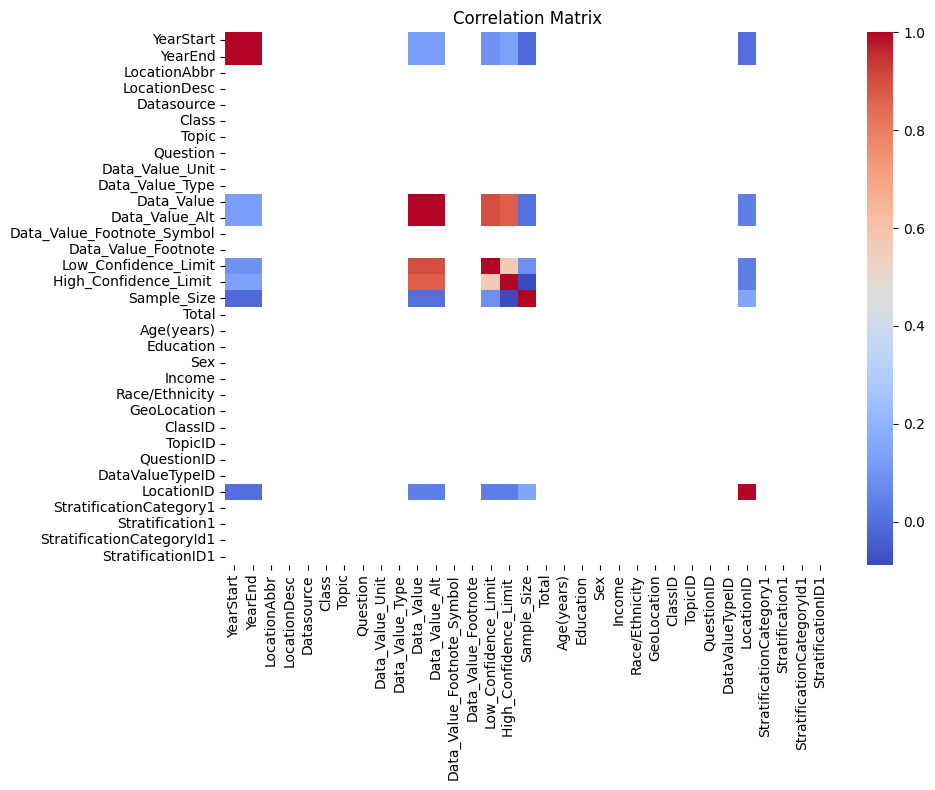

In [223]:
corr = df_num.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()

plt.savefig("data/EDA Findings/correlation_matrix.png", dpi=300)

plt.show()


## Histograms of Numeric columns

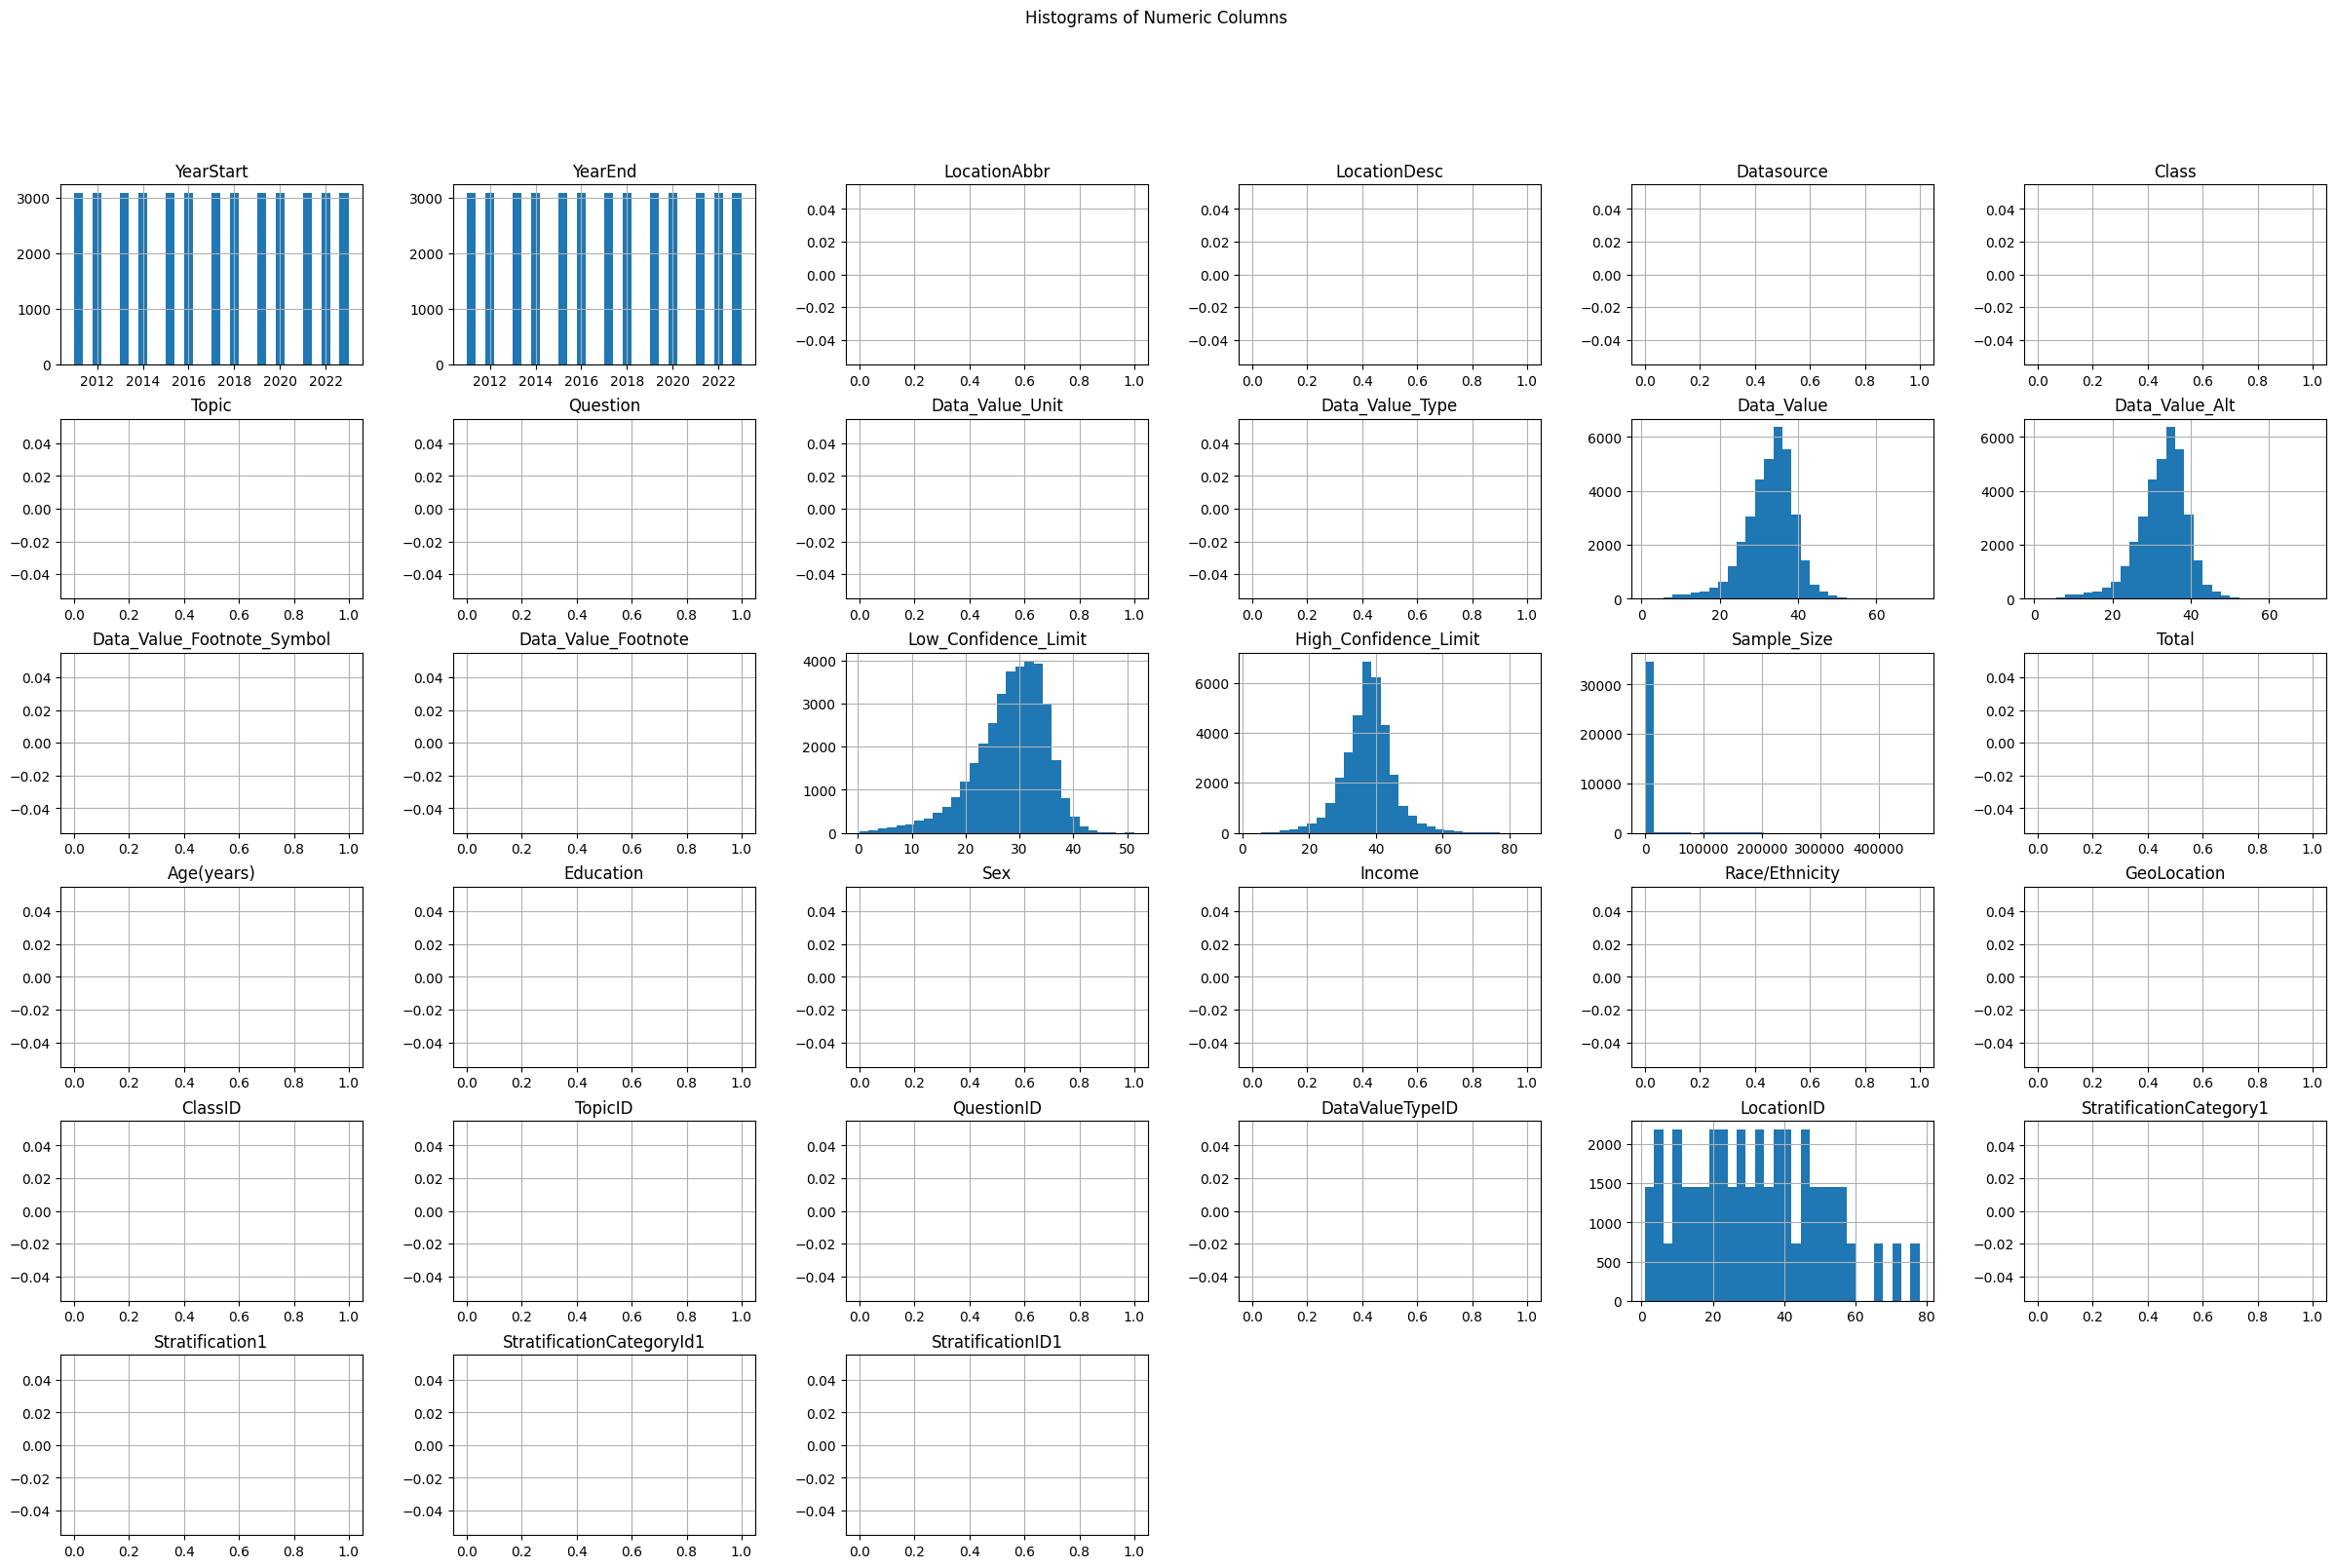

In [224]:
df_num.hist(figsize=(30, 18), bins=30)
plt.suptitle("Histograms of Numeric Columns")

plt.savefig("data/EDA Findings/histograms_of_numeric_columns.png", dpi=300)

plt.show()

## Scatter Plot

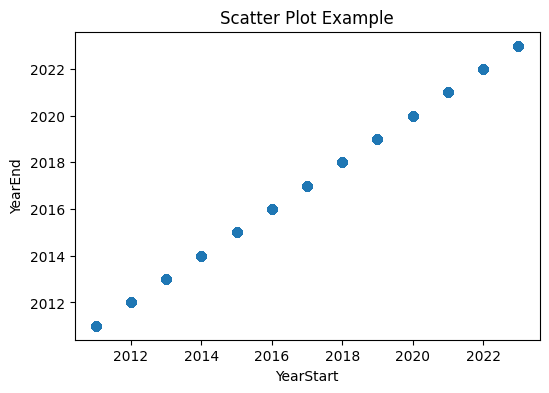

In [225]:
plt.figure(figsize=(6, 4))
plt.scatter(df_num.iloc[:, 0], df_num.iloc[:, 1])
plt.xlabel(df_num.columns[0])
plt.ylabel(df_num.columns[1])
plt.title("Scatter Plot Example")

plt.savefig("data/EDA Findings/scatter_plot.png", dpi=300)

plt.show()

# Data Preparation

In [226]:
display(df.head(1))

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Total,Age(years),Education,Sex,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,34.8,34.8,NaN,NaN,31.3,38.5,1367,NaN,NaN,NaN,NaN,"$15,000 - $24,999",NaN,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,01,Income,"$15,000 - $24,999",INC,INC1525


## Getting the needed columns

In [227]:
df.columns = df.columns.str.strip()

cols_to_keep = [
    "YearStart","LocationAbbr","LocationDesc","Education","Sex","Income",
    "Race/Ethnicity","Sample_Size","Low_Confidence_Limit","High_Confidence_Limit",
    "Data_Value"
]

existing = [c for c in cols_to_keep if c in df.columns]
missing = [c for c in cols_to_keep if c not in df.columns]
print("Keeping columns:", existing)
if missing:
    print("WARNING - missing (will proceed without):", missing)

df = df[existing].copy()


Keeping columns: ['YearStart', 'LocationAbbr', 'LocationDesc', 'Education', 'Sex', 'Income', 'Race/Ethnicity', 'Sample_Size', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value']


## Handing missing values

In [228]:
num_cols = ["YearStart","Sample_Size",
            "Low_Confidence_Limit","High_Confidence_Limit","Data_Value"]
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in df.columns if c not in num_cols]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df = df.copy()


In [229]:
display(df)

,YearStart,LocationAbbr,LocationDesc,Education,Sex,Income,Race/Ethnicity,Sample_Size,Low_Confidence_Limit,High_Confidence_Limit,Data_Value
0,2011,AL,Alabama,College graduate,Female,"$15,000 - $24,999",2 or more races,1367.0,31.3,38.5,34.8
1,2011,AL,Alabama,College graduate,Female,"$25,000 - $34,999",2 or more races,757.0,31.1,40.8,35.8
2,2011,AL,Alabama,College graduate,Female,"$35,000 - $49,999",2 or more races,861.0,28.0,36.8,32.3
3,2011,AL,Alabama,College graduate,Female,"$50,000 - $74,999",2 or more races,785.0,29.7,38.8,34.1
4,2011,AL,Alabama,College graduate,Female,"$75,000 or greater",2 or more races,1125.0,25.4,32.5,28.8
...,...,...,...,...,...,...,...,...,...,...,...
98555,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Non-Hispanic Black,1226.0,32.3,41.5,36.8
98556,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Non-Hispanic White,225.0,33.1,53.9,43.2
98557,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Other,61.0,18.1,63.9,38.5
98558,2023,VI,Virgin Islands,Some college or technical sch,Female,"$15,000 - $24,999",2 or more races,373.0,31.2,49.6,40.1


In [230]:
df.isna().sum()

YearStart                0
LocationAbbr             0
LocationDesc             0
Education                0
Sex                      0
Income                   0
Race/Ethnicity           0
Sample_Size              0
Low_Confidence_Limit     0
High_Confidence_Limit    0
Data_Value               0
dtype: int64

## Correcting Error Data

In [231]:
df[num_cols] = df[num_cols].clip(lower=0)

# Ensure Low <= High
df["Low_Confidence_Limit"], df["High_Confidence_Limit"] = (
    df[["Low_Confidence_Limit","High_Confidence_Limit"]].min(axis=1),
    df[["Low_Confidence_Limit","High_Confidence_Limit"]].max(axis=1)
)


## Scaling

In [232]:
num_cols = ["Sample_Size",
            "Low_Confidence_Limit","High_Confidence_Limit","Data_Value"]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [233]:
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [234]:
display(df)

,YearStart,LocationAbbr,LocationDesc,Education,Sex,Income,Race/Ethnicity,Sample_Size,Low_Confidence_Limit,High_Confidence_Limit,Data_Value
0,2011,AL,Alabama,College graduate,Female,"$15,000 - $24,999",2 or more races,-0.112194,0.464979,0.111269,0.329369
1,2011,AL,Alabama,College graduate,Female,"$25,000 - $34,999",2 or more races,-0.147094,0.433212,0.442522,0.495422
2,2011,AL,Alabama,College graduate,Female,"$35,000 - $49,999",2 or more races,-0.141144,-0.059163,-0.133570,-0.085763
3,2011,AL,Alabama,College graduate,Female,"$50,000 - $74,999",2 or more races,-0.145492,0.210849,0.154476,0.213132
4,2011,AL,Alabama,College graduate,Female,"$75,000 or greater",2 or more races,-0.126040,-0.472124,-0.752868,-0.666949
...,...,...,...,...,...,...,...,...,...,...,...
98555,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Non-Hispanic Black,-0.120261,0.623809,0.543338,0.661475
98556,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Non-Hispanic White,-0.177532,0.750874,2.329220,1.724214
98557,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Other,-0.186915,-1.631589,3.769448,0.943765
98558,2023,VI,Virgin Islands,Some college or technical sch,Female,"$15,000 - $24,999",2 or more races,-0.169065,0.449095,1.709922,1.209450


## Feature Engineering

In [235]:
df["Confidence_Range"] = (
    df["High_Confidence_Limit"] - df["Low_Confidence_Limit"]
)

df["Value_Per_Sample"] = (
    df["Data_Value"] / (df["Sample_Size"] + 1e-6)
)


In [236]:
display(df)

,YearStart,LocationAbbr,LocationDesc,Education,Sex,Income,Race/Ethnicity,Sample_Size,Low_Confidence_Limit,High_Confidence_Limit,Data_Value,Confidence_Range,Value_Per_Sample
0,2011,AL,Alabama,College graduate,Female,"$15,000 - $24,999",2 or more races,-0.112194,0.464979,0.111269,0.329369,-0.353709,-2.935739
1,2011,AL,Alabama,College graduate,Female,"$25,000 - $34,999",2 or more races,-0.147094,0.433212,0.442522,0.495422,0.009309,-3.368077
2,2011,AL,Alabama,College graduate,Female,"$35,000 - $49,999",2 or more races,-0.141144,-0.059163,-0.133570,-0.085763,-0.074406,0.607633
3,2011,AL,Alabama,College graduate,Female,"$50,000 - $74,999",2 or more races,-0.145492,0.210849,0.154476,0.213132,-0.056373,-1.464912
4,2011,AL,Alabama,College graduate,Female,"$75,000 or greater",2 or more races,-0.126040,-0.472124,-0.752868,-0.666949,-0.280744,5.291616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98555,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Non-Hispanic Black,-0.120261,0.623809,0.543338,0.661475,-0.080472,-5.500370
98556,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Non-Hispanic White,-0.177532,0.750874,2.329220,1.724214,1.578346,-9.712171
98557,2023,VI,Virgin Islands,College graduate,Female,"$15,000 - $24,999",Other,-0.186915,-1.631589,3.769448,0.943765,5.401037,-5.049185
98558,2023,VI,Virgin Islands,Some college or technical sch,Female,"$15,000 - $24,999",2 or more races,-0.169065,0.449095,1.709922,1.209450,1.260827,-7.153816


## Train/Test Split

In [237]:
X = pd.get_dummies(df.drop("Data_Value", axis=1), drop_first=True)
y = df["Data_Value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model Training

## Linear Regression

In [238]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

## Random Forest

In [239]:
rf = RandomForestRegressor()
params = {"n_estimators":[100,200], "max_depth":[None,10,20]}
grid_rf = GridSearchCV(rf, params, cv=3)
grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_
rf_pred = rf_best.predict(X_test)

## Gradient Boosting Regressor

In [240]:
gbr = GradientBoostingRegressor()
params_gbr = {"n_estimators":[100,200], "learning_rate":[0.05,0.1]}
grid_gbr = GridSearchCV(gbr, params_gbr, cv=3)
grid_gbr.fit(X_train, y_train)
gbr_best = grid_gbr.best_estimator_
gbr_pred = gbr_best.predict(X_test)


## Evaluation

In [241]:
results = []

models = {
    "Linear Regression": lr_pred,
    "Random Forest": rf_pred,
    "Gradient Boosting": gbr_pred
}

for name, preds in models.items():
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append([name, mae, rmse, r2])

df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"])
print(df_results)


               Model       MAE      RMSE        R²
0  Linear Regression  0.024969  0.044421  0.998066
1      Random Forest  0.005934  0.013254  0.999828
2  Gradient Boosting  0.022064  0.031863  0.999005


In [243]:
joblib.dump(rf_best, "models/best_model.pkl", compress=3)
joblib.dump(X_train.columns, "models/model_features.pkl")

['models/model_features.pkl']